In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys
sys.path.append(os.path.dirname(os.path.abspath(os.path.join('../'))))

In [2]:
import numpy
import torchvision

train = torchvision.datasets.MNIST('mnist', train = True, download = False)
test = torchvision.datasets.MNIST('mnist', train = False, download = False)

train_images = numpy.array([ numpy.array(item[0]) for item in train ])[:1000]
train_labels = numpy.array([ item[1] for item in train ])[:1000]

test_images = numpy.array([ numpy.array(item[0]) for item in test ])[:250]
test_labels = numpy.array([ item[1] for item in test ])[:250]

In [3]:
import itertools
import cvtda.utils
import cvtda.topology

### Greyscale To smth

In [4]:
greyscale_to_filtrations = cvtda.topology.GreyscaleToFiltrations(
    radial_filtration_centers=list(itertools.product([ 3, 8, 13, 18, 23 ], [ 3, 8, 13, 18, 23 ]))
)

train_filtrations = greyscale_to_filtrations.fit_transform(train_images)
test_filtrations = greyscale_to_filtrations.transform(test_images)

Fitting the binarizer


Fitting the filtrations: 100%|██████████| 38/38 [00:00<00:00, 3728.44it/s]


Fitting the inverter


Fitting the inverted filtrations: 100%|██████████| 38/38 [00:00<00:00, 3877.19it/s]


Fitting complete


Inverted filtrations: 100%|██████████| 38/38 [00:00<00:00, 66.83it/s]


In [5]:
greyscale_to_pointclouds = cvtda.topology.GreyscaleToPointClouds()

train_pointclouds = greyscale_to_pointclouds.fit_transform(train_images)
test_pointclouds = greyscale_to_pointclouds.transform(test_images)

len(train_pointclouds[0][1])

Fitting the binarizer
Fitting the inverter
Fitting the converter
Fitting image_to_point_cloud
Fitting complete
Applying the binarizer
Applying the inverter


Converting images to point clouds: 100%|██████████| 1000/1000 [00:00<00:00, 49583.34it/s]


Converting binary to point clouds


Combining the point clouds:   0%|          | 0/1000 [00:00<?, ?it/s]

Applying the binarizer
Applying the inverter


Converting images to point clouds: 100%|██████████| 250/250 [00:00<00:00, 41814.25it/s]

Converting binary to point clouds


Combining the point clouds:   0%|          | 0/250 [00:00<?, ?it/s]

145

### Flatten

In [6]:
filtrations_flatten = cvtda.utils.FlattenBatch()

train_filtrations = filtrations_flatten.fit_transform(train_filtrations)
test_filtrations = filtrations_flatten.transform(test_filtrations)

train_filtrations.shape

(79000, 28, 28)

In [7]:
pointclouds_flatten = cvtda.utils.FlattenBatch()

train_pointclouds = pointclouds_flatten.fit_transform(train_pointclouds)
test_pointclouds = pointclouds_flatten.transform(test_pointclouds)

len(train_pointclouds)

2000

### Diagrams

In [8]:
filtrations_to_diagrams = cvtda.topology.FiltrationsToDiagrams()

train_filtration_diagrams = filtrations_to_diagrams.fit_transform(train_filtrations)
test_filtration_diagrams = filtrations_to_diagrams.transform(test_filtrations)

train_filtration_diagrams.shape

Fitting the persistence
Fitting complete
Calculating the persistence
Calculating the persistence


(79000, 53, 3)

In [9]:
pointclouds_to_diagrams = cvtda.topology.PointCloudsToDiagrams()

train_pointcloud_diagrams = pointclouds_to_diagrams.fit_transform(train_pointclouds)
test_pointcloud_diagrams = pointclouds_to_diagrams.transform(test_pointclouds)

train_pointcloud_diagrams.shape

Fitting the persistence
Fitting complete
Calculating the persistence
Calculating the persistence


(2000, 512, 3)

### Features

In [10]:
filtration_features = cvtda.topology.DiagramsToFeatures(n_bins = 32)

train_filtration_features = filtration_features.fit_transform(train_filtration_diagrams)
test_filtration_features = filtration_features.transform(test_filtration_diagrams)

train_filtration_features.shape

Fitting the calculator
Fitting the filtering
Fitting the betti curve
Fitting the persistence landscape


Fitting the silhouettes: 100%|██████████| 2/2 [00:00<00:00,  4.43it/s]


Fitting the persistence entropy
Fitting the number of points


Fitting the persistence images: 100%|██████████| 3/3 [00:00<00:00,  4.05it/s]


Fitting complete


Batch: 100%|██████████| 5/5 [00:04<00:00,  1.02it/s]


(79000, 260)

In [11]:
pointcloud_features = cvtda.topology.DiagramsToFeatures(batch_size = 100)

train_pointcloud_features = pointcloud_features.fit_transform(train_pointcloud_diagrams)
test_pointcloud_features = pointcloud_features.transform(test_pointcloud_diagrams)

train_pointcloud_features.shape

Fitting the calculator
Fitting the filtering
Fitting the betti curve
Fitting the persistence landscape


Fitting the silhouettes: 100%|██████████| 2/2 [00:00<00:00, 16.60it/s]


Fitting the persistence entropy
Fitting the number of points


Fitting the persistence images: 100%|██████████| 3/3 [00:00<00:00, 15.78it/s]


Fitting complete


Batch: 100%|██████████| 5/5 [00:03<00:00,  1.45it/s]


(2000, 390)

### Unflat

In [12]:
train_filtration_features = filtrations_flatten.inverse_transform(train_filtration_features)
test_filtration_features = filtrations_flatten.inverse_transform(test_filtration_features)

train_filtration_features.shape

(1000, 79, 260)

In [13]:
train_pointcloud_features = pointclouds_flatten.inverse_transform(train_pointcloud_features)
test_pointcloud_features = pointclouds_flatten.inverse_transform(test_pointcloud_features)

train_pointcloud_features.shape

(1000, 2, 390)

In [14]:
train_features = numpy.hstack([
    train_filtration_features.reshape((len(train_filtration_features), -1)),
    train_pointcloud_features.reshape((len(train_pointcloud_features), -1))
])
test_features = numpy.hstack([
    test_filtration_features.reshape((len(test_filtration_features), -1)),
    test_pointcloud_features.reshape((len(test_pointcloud_features), -1))
])

train_features.shape

(1000, 21320)

### Classifier

In [15]:
import cvtda.classification
train_features = numpy.minimum(train_features, 1e9)
test_features = numpy.minimum(test_features, 1e9)

#### Raw features

Fitting KNeighborsClassifier(n_jobs=-1, n_neighbors=10)
Fitting DecisionTreeClassifier(random_state=42)
Fitting RandomForestClassifier(n_jobs=-1, random_state=42)
Fitting <cvtda.classification.NNClassifier.NNClassifier object at 0x1034d3d90>


100%|██████████| 100/100 [00:16<00:00,  6.02it/s, loss=1.57e+3]


Fitting HistGradientBoostingClassifier(max_depth=4, max_iter=25, random_state=42)
Fitting XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=-1,
              num_parallel_tree=None, random_state=None, ...)


,classifier,Accuracy,TOP-2 Accuracy,TOP-3 Accuracy,TOP-4 Accuracy,TOP-5 Accuracy,TOP-6 Accuracy,TOP-7 Accuracy,TOP-8 Accuracy,TOP-9 Accuracy,AUC-ROC,Precision,Recall,F1-score
0,KNeighborsClassifier,0.592,0.704,0.796,0.872,0.928,0.940,0.952,0.980,0.996,0.863736,0.563845,0.568550,0.557842
1,DecisionTreeClassifier,0.804,0.844,0.868,0.892,0.908,0.940,0.944,0.988,1.000,0.885063,0.795079,0.793113,0.789160
2,RandomForestClassifier,0.928,0.972,0.984,0.992,0.992,0.996,1.000,1.000,1.000,0.995505,0.922425,0.925468,0.923218
3,NNClassifier,0.856,0.888,0.912,0.924,0.932,0.940,0.948,0.960,0.996,0.957057,0.775971,0.820004,0.789622
4,HistGradientBoostingClassifier,0.928,0.956,0.980,0.988,0.988,0.988,0.992,1.000,1.000,0.993978,0.921457,0.921506,0.920798
5,XGBClassifier,0.936,0.952,0.968,0.980,0.992,0.996,0.996,1.000,1.000,0.992489,0.931558,0.930219,0.929784


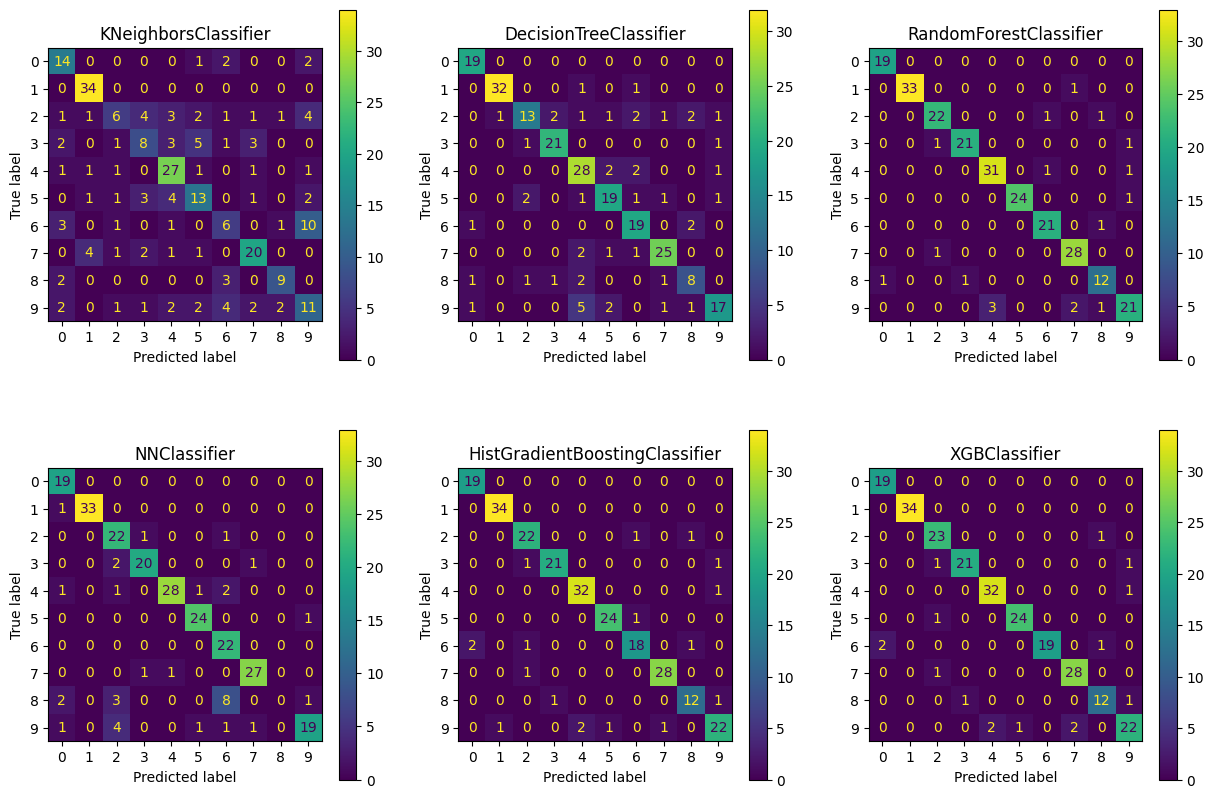

In [16]:
cvtda.classification.classify(
    train_features, train_labels, test_features, test_labels,
    nn_device = 'mps', nn_epochs = 100, nn_batch_size = 64
)

#### StandardScaler

In [17]:
import sklearn.preprocessing

standard_scaler = sklearn.preprocessing.StandardScaler()
train_features_scaled = standard_scaler.fit_transform(train_features)
test_features_scaled = standard_scaler.transform(test_features)

Fitting KNeighborsClassifier(n_jobs=-1, n_neighbors=10)
Fitting DecisionTreeClassifier(random_state=42)
Fitting RandomForestClassifier(n_jobs=-1, random_state=42)
Fitting <cvtda.classification.NNClassifier.NNClassifier object at 0x148cc4370>


100%|██████████| 100/100 [00:15<00:00,  6.31it/s, loss=1.5e+3]


Fitting HistGradientBoostingClassifier(max_depth=4, max_iter=25, random_state=42)
Fitting XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=-1,
              num_parallel_tree=None, random_state=None, ...)


,classifier,Accuracy,TOP-2 Accuracy,TOP-3 Accuracy,TOP-4 Accuracy,TOP-5 Accuracy,TOP-6 Accuracy,TOP-7 Accuracy,TOP-8 Accuracy,TOP-9 Accuracy,AUC-ROC,Precision,Recall,F1-score
0,KNeighborsClassifier,0.872,0.932,0.968,0.980,0.984,0.984,0.988,0.996,1.000,0.972603,0.877532,0.856152,0.860341
1,DecisionTreeClassifier,0.808,0.844,0.868,0.880,0.916,0.940,0.944,0.992,1.000,0.885221,0.793771,0.793397,0.789820
2,RandomForestClassifier,0.928,0.964,0.980,0.984,0.996,0.996,1.000,1.000,1.000,0.995067,0.921626,0.924626,0.922588
3,NNClassifier,0.916,0.948,0.952,0.960,0.964,0.972,0.976,0.976,0.996,0.988530,0.913967,0.910860,0.907832
4,HistGradientBoostingClassifier,0.924,0.948,0.972,0.988,0.988,0.992,0.992,0.996,1.000,0.993092,0.918240,0.917506,0.917084
5,XGBClassifier,0.940,0.960,0.968,0.980,0.992,0.996,0.996,1.000,1.000,0.992530,0.935250,0.934219,0.933700


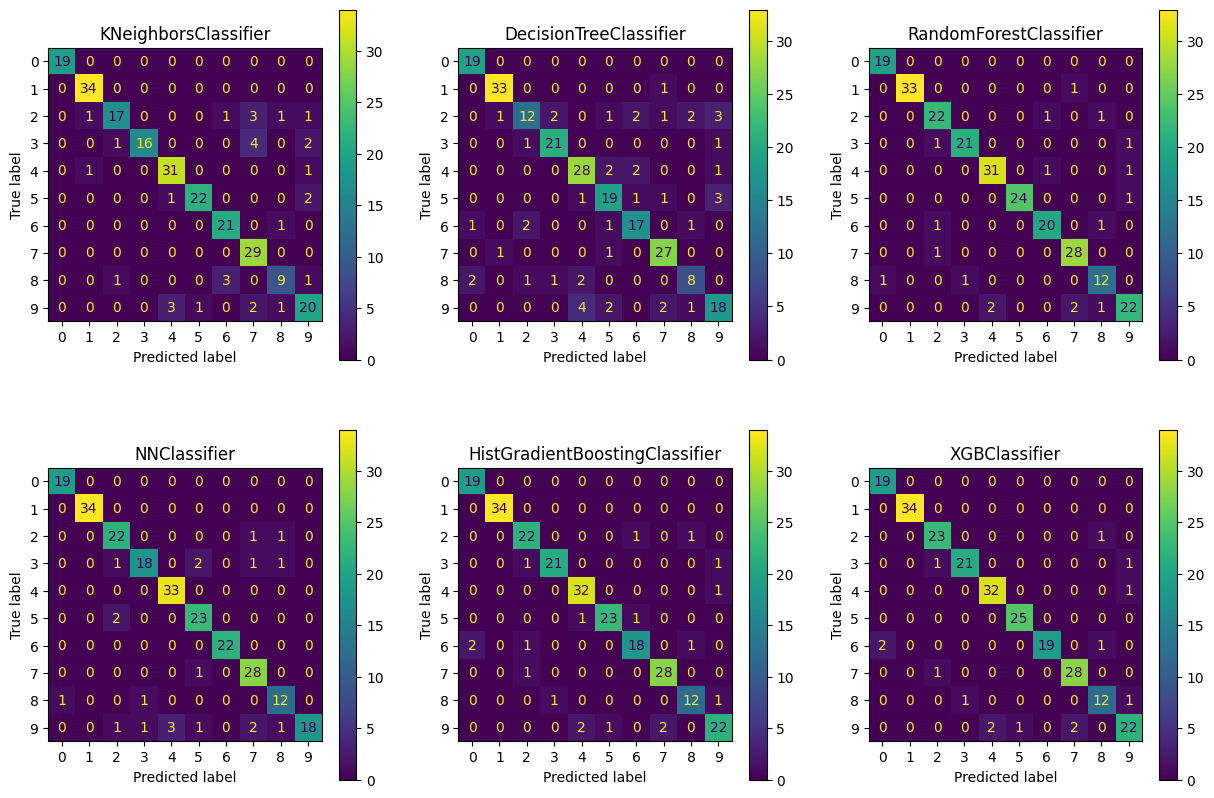

In [18]:
cvtda.classification.classify(
    train_features_scaled, train_labels, test_features_scaled, test_labels,
    nn_device = 'mps', nn_epochs = 100, nn_batch_size = 64
)

#### PCA

In [19]:
import sklearn.decomposition

pca = sklearn.decomposition.PCA(n_components = 128, random_state = 42)

train_features_pca = pca.fit_transform(train_features_scaled)
print('Explained variance', round(pca.explained_variance_ratio_.sum(), 2))
print([ round(x, 3) for x in pca.explained_variance_ratio_ ])

test_features_pca = pca.transform(test_features_scaled)

Explained variance 0.95
[0.351, 0.131, 0.05, 0.039, 0.032, 0.024, 0.02, 0.018, 0.017, 0.014, 0.011, 0.01, 0.01, 0.009, 0.008, 0.008, 0.007, 0.007, 0.006, 0.005, 0.005, 0.005, 0.004, 0.004, 0.004, 0.004, 0.004, 0.004, 0.003, 0.003, 0.003, 0.003, 0.003, 0.003, 0.003, 0.003, 0.003, 0.003, 0.003, 0.003, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001]


Fitting KNeighborsClassifier(n_jobs=-1, n_neighbors=10)
Fitting DecisionTreeClassifier(random_state=42)
Fitting RandomForestClassifier(n_jobs=-1, random_state=42)
Fitting <cvtda.classification.NNClassifier.NNClassifier object at 0x148b645e0>


100%|██████████| 100/100 [00:13<00:00,  7.56it/s, loss=1.47e+3]


Fitting HistGradientBoostingClassifier(max_depth=4, max_iter=25, random_state=42)
Fitting XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=-1,
              num_parallel_tree=None, random_state=None, ...)


,classifier,Accuracy,TOP-2 Accuracy,TOP-3 Accuracy,TOP-4 Accuracy,TOP-5 Accuracy,TOP-6 Accuracy,TOP-7 Accuracy,TOP-8 Accuracy,TOP-9 Accuracy,AUC-ROC,Precision,Recall,F1-score
0,KNeighborsClassifier,0.896,0.948,0.976,0.984,0.984,0.984,0.988,0.996,1.000,0.973407,0.898626,0.880127,0.883603
1,DecisionTreeClassifier,0.736,0.780,0.796,0.840,0.852,0.896,0.924,0.984,0.992,0.846316,0.724839,0.723368,0.719404
2,RandomForestClassifier,0.888,0.948,0.976,0.976,0.988,0.992,0.996,1.000,1.000,0.988244,0.886322,0.880902,0.880159
3,NNClassifier,0.924,0.952,0.972,0.976,0.980,0.992,0.996,1.000,1.000,0.990287,0.922812,0.915039,0.916984
4,HistGradientBoostingClassifier,0.852,0.948,0.964,0.988,0.992,0.996,0.996,1.000,1.000,0.983345,0.846298,0.847961,0.844630
5,XGBClassifier,0.868,0.952,0.980,0.984,0.996,0.996,0.996,0.996,1.000,0.988115,0.865411,0.864159,0.862339


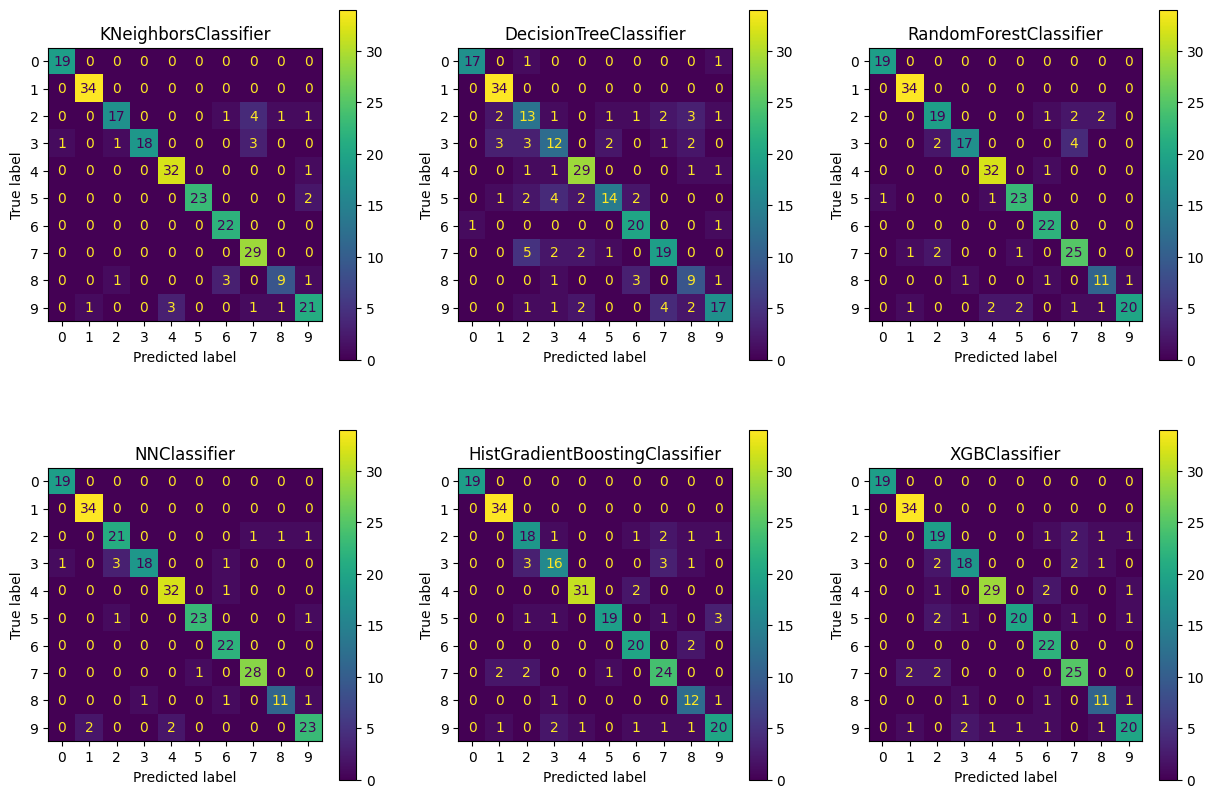

In [20]:
cvtda.classification.classify(
    train_features_pca, train_labels, test_features_pca, test_labels,
    nn_device = 'mps', nn_epochs = 100, nn_batch_size = 64
)

#### UMAP

In [21]:
import umap

umap_ = umap.UMAP(n_components = 128, n_jobs = -1)
train_features_umap = umap_.fit_transform(train_features)
test_features_umap = umap_.transform(test_features)

Fitting KNeighborsClassifier(n_jobs=-1, n_neighbors=10)
Fitting DecisionTreeClassifier(random_state=42)
Fitting RandomForestClassifier(n_jobs=-1, random_state=42)
Fitting <cvtda.classification.NNClassifier.NNClassifier object at 0x152835060>


100%|██████████| 100/100 [00:12<00:00,  7.82it/s, loss=2.03e+3]


Fitting HistGradientBoostingClassifier(max_depth=4, max_iter=25, random_state=42)
Fitting XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=-1,
              num_parallel_tree=None, random_state=None, ...)


,classifier,Accuracy,TOP-2 Accuracy,TOP-3 Accuracy,TOP-4 Accuracy,TOP-5 Accuracy,TOP-6 Accuracy,TOP-7 Accuracy,TOP-8 Accuracy,TOP-9 Accuracy,AUC-ROC,Precision,Recall,F1-score
0,KNeighborsClassifier,0.480,0.628,0.708,0.796,0.856,0.876,0.920,0.952,0.992,0.801025,0.455041,0.466046,0.452335
1,DecisionTreeClassifier,0.400,0.492,0.508,0.612,0.660,0.756,0.832,0.932,0.956,0.656856,0.380901,0.382342,0.378196
2,RandomForestClassifier,0.456,0.616,0.720,0.848,0.908,0.948,0.956,0.984,0.992,0.837846,0.436929,0.433560,0.430833
3,NNClassifier,0.368,0.528,0.644,0.756,0.844,0.904,0.948,0.968,1.000,0.809970,0.320180,0.352389,0.300875
4,HistGradientBoostingClassifier,0.500,0.644,0.748,0.848,0.912,0.960,0.976,0.996,0.996,0.846682,0.490989,0.487021,0.477645
5,XGBClassifier,0.452,0.612,0.700,0.784,0.900,0.968,0.988,0.992,0.996,0.831926,0.420896,0.433950,0.420819


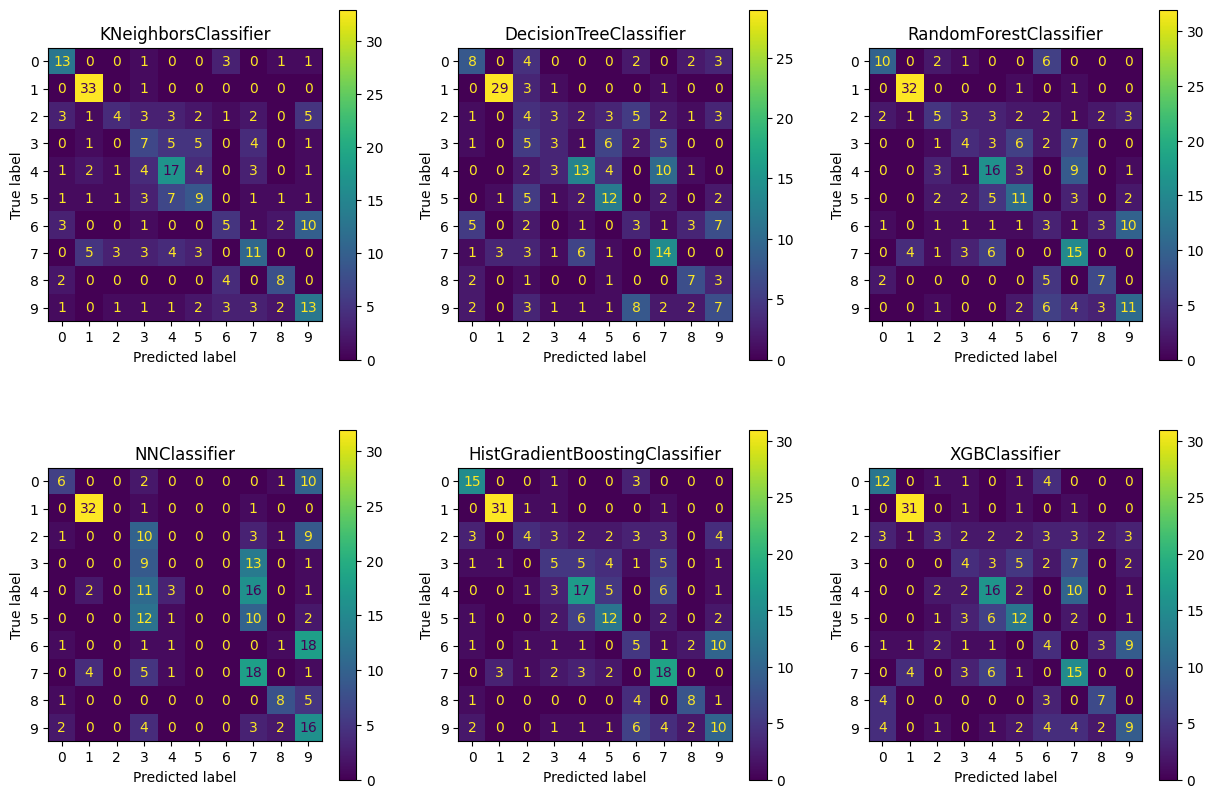

In [22]:
cvtda.classification.classify(
    train_features_umap, train_labels, test_features_umap, test_labels,
    nn_device = 'mps', nn_epochs = 100, nn_batch_size = 64
)

### Information value

IV: 100%|██████████| 21320/21320 [01:12<00:00, 292.97it/s]


<Axes: >

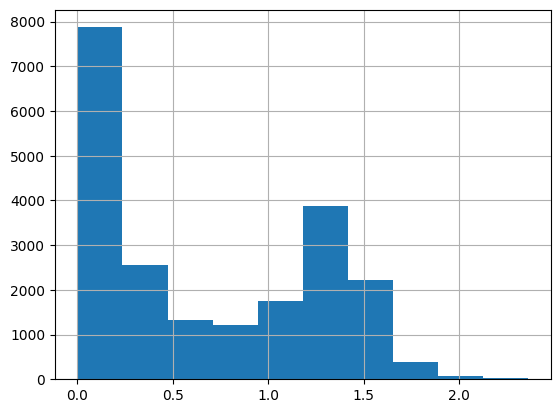

In [27]:
cvtda.classification.calculate_information_value(
    train_features_scaled,
    train_labels,
    bins = 50
)['IV'].hist()

In [42]:
feature_selector = cvtda.classification.InformationValueFeatureSelector(threshold = 0.25, bins = 50)

train_features_selected = feature_selector.fit_transform(train_features, train_labels)
test_features_selected = feature_selector.transform(test_features)

train_features_selected.shape

Fitting the information value feature selector


information values: 100%|██████████| 21320/21320 [01:12<00:00, 293.67it/s]

Fitting complete


(1000, 13279)

In [43]:
import sklearn.preprocessing

selected_standard_scaler = sklearn.preprocessing.StandardScaler()
train_features_selected_scaled = selected_standard_scaler.fit_transform(train_features_selected)
test_features_selected_scaled = selected_standard_scaler.transform(test_features_selected)

train_features_selected_scaled.shape

(1000, 13279)

Fitting KNeighborsClassifier(n_jobs=-1, n_neighbors=10)
Fitting DecisionTreeClassifier(random_state=42)
Fitting RandomForestClassifier(n_jobs=-1, random_state=42)
Fitting <cvtda.classification.NNClassifier.NNClassifier object at 0x3c392fa30>


100%|██████████| 100/100 [00:21<00:00,  4.67it/s, loss=1.49e+3]


Fitting HistGradientBoostingClassifier(max_depth=4, max_iter=25, random_state=42)
Fitting XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=-1,
              num_parallel_tree=None, random_state=None, ...)


,classifier,Accuracy,TOP-2 Accuracy,TOP-3 Accuracy,TOP-4 Accuracy,TOP-5 Accuracy,TOP-6 Accuracy,TOP-7 Accuracy,TOP-8 Accuracy,TOP-9 Accuracy,AUC-ROC,Precision,Recall,F1-score
0,KNeighborsClassifier,0.900,0.936,0.968,0.980,0.984,0.984,0.988,0.992,1.0,0.976687,0.903238,0.887089,0.890304
1,DecisionTreeClassifier,0.816,0.868,0.888,0.892,0.924,0.948,0.948,0.988,1.0,0.889263,0.804300,0.800674,0.797942
2,RandomForestClassifier,0.932,0.968,0.988,0.988,0.988,0.988,1.000,1.000,1.0,0.995491,0.928597,0.929171,0.928414
3,NNClassifier,0.932,0.968,0.976,0.984,0.992,1.000,1.000,1.000,1.0,0.990795,0.926896,0.927685,0.926466
4,HistGradientBoostingClassifier,0.924,0.960,0.976,0.988,0.988,0.992,0.992,0.996,1.0,0.993519,0.922563,0.917506,0.918628
5,XGBClassifier,0.924,0.960,0.972,0.980,0.988,0.992,0.996,1.000,1.0,0.992130,0.916529,0.915205,0.914952


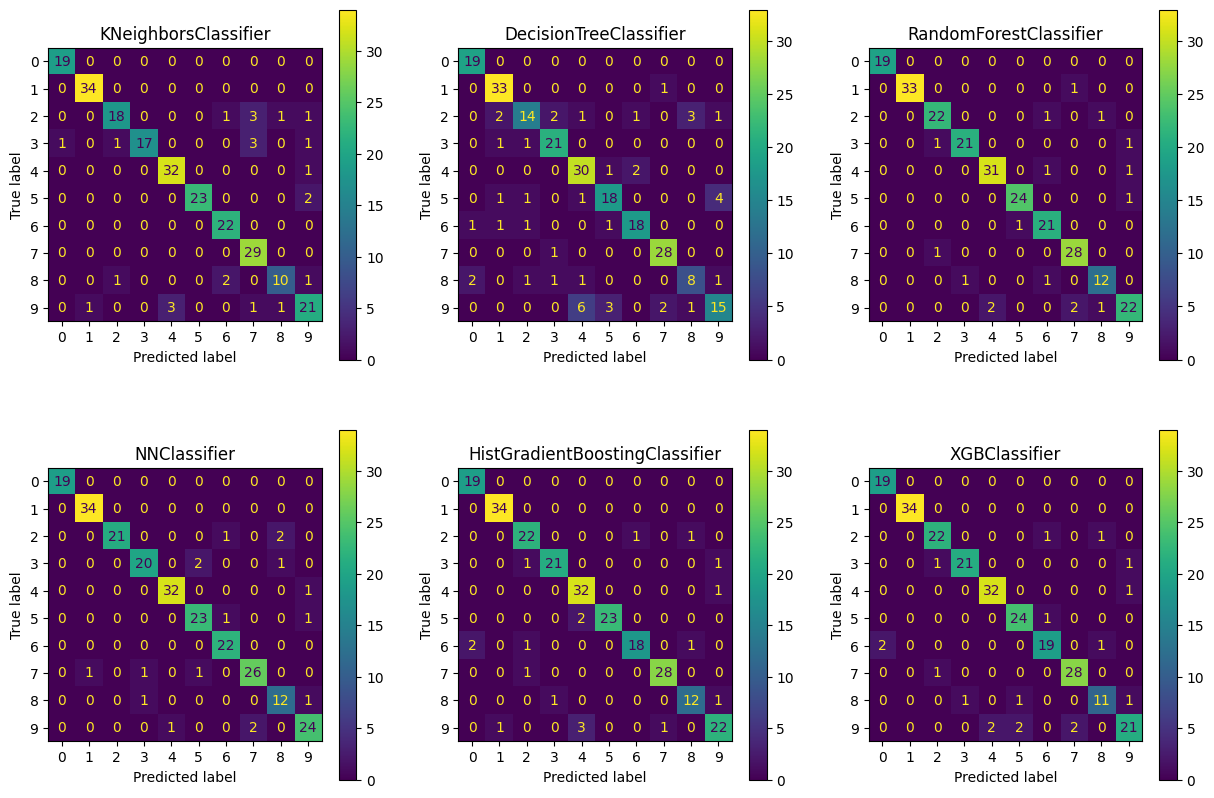

In [44]:
cvtda.classification.classify(
    train_features_selected_scaled, train_labels, test_features_selected_scaled, test_labels,
    nn_device = 'mps', nn_epochs = 100, nn_batch_size = 64
)

### Correlation selector

/opt/homebrew/lib/python3.10/site-packages/numpy/lib/function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/opt/homebrew/lib/python3.10/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


(array([4.436e+03, 0.000e+00, 0.000e+00, 4.000e+00, 3.140e+02, 9.970e+02,
        4.360e+03, 4.432e+03, 6.293e+03, 4.840e+02]),
 array([-1.        , -0.85125984, -0.70251969, -0.55377953, -0.40503937,
        -0.25629921, -0.10755906,  0.0411811 ,  0.18992126,  0.33866142,
         0.48740157]),
 <BarContainer object of 10 artists>)

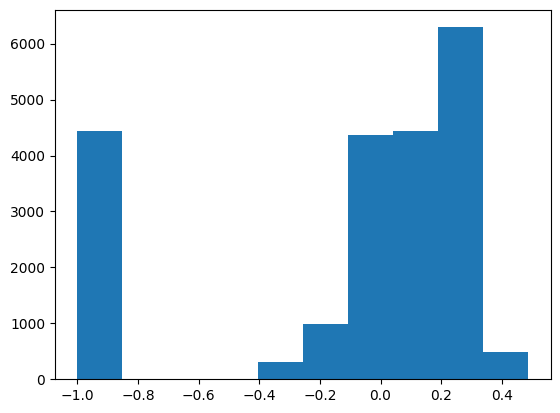

In [ ]:
import matplotlib.pyplot as plt

plt.hist(cvtda.classification.correlate_with_target(train_features, train_labels))

In [84]:
feature_selector = cvtda.classification.CorrelationSelector(threshold = -0.1)

train_features_selected = feature_selector.fit_transform(train_features, train_labels)
test_features_selected = feature_selector.transform(test_features)

train_features_selected.shape

Fitting the correlations feature selector


/opt/homebrew/lib/python3.10/site-packages/numpy/lib/function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/opt/homebrew/lib/python3.10/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Fitting complete


(1000, 15498)

In [85]:
import sklearn.preprocessing

selected_standard_scaler = sklearn.preprocessing.StandardScaler()
train_features_selected_scaled = selected_standard_scaler.fit_transform(train_features_selected)
test_features_selected_scaled = selected_standard_scaler.transform(test_features_selected)

train_features_selected_scaled.shape

(1000, 15498)

Fitting KNeighborsClassifier(n_jobs=-1, n_neighbors=10)
Fitting DecisionTreeClassifier(random_state=42)
Fitting RandomForestClassifier(n_jobs=-1, random_state=42)
Fitting <cvtda.classification.NNClassifier.NNClassifier object at 0x3c53de050>


100%|██████████| 100/100 [00:23<00:00,  4.24it/s, loss=1.49e+3]


Fitting HistGradientBoostingClassifier(max_depth=4, max_iter=25, random_state=42)
Fitting XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=-1,
              num_parallel_tree=None, random_state=None, ...)


,classifier,Accuracy,TOP-2 Accuracy,TOP-3 Accuracy,TOP-4 Accuracy,TOP-5 Accuracy,TOP-6 Accuracy,TOP-7 Accuracy,TOP-8 Accuracy,TOP-9 Accuracy,AUC-ROC,Precision,Recall,F1-score
0,KNeighborsClassifier,0.856,0.924,0.964,0.976,0.980,0.980,0.984,0.992,1.0,0.969500,0.864040,0.848446,0.847093
1,DecisionTreeClassifier,0.836,0.884,0.904,0.916,0.928,0.948,0.948,0.992,1.0,0.900281,0.829266,0.820505,0.819736
2,RandomForestClassifier,0.908,0.964,0.984,0.988,0.992,0.996,0.996,1.000,1.0,0.994893,0.904912,0.904496,0.903603
3,NNClassifier,0.924,0.952,0.956,0.960,0.964,0.968,0.972,0.988,1.0,0.983467,0.920340,0.920155,0.918619
4,HistGradientBoostingClassifier,0.916,0.956,0.976,0.988,0.988,0.992,0.992,0.996,1.0,0.992572,0.909219,0.910433,0.908495
5,XGBClassifier,0.920,0.960,0.964,0.984,0.988,0.988,0.996,0.996,1.0,0.993481,0.910374,0.914311,0.910409


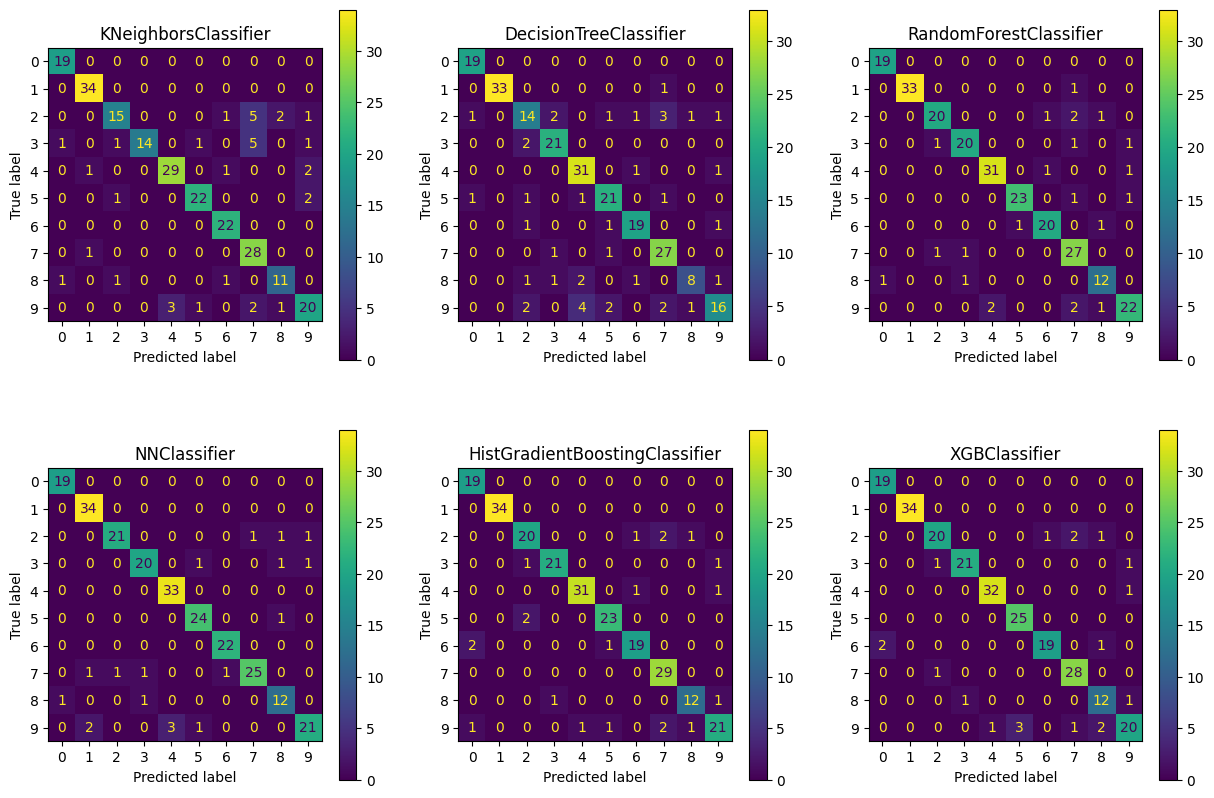

In [86]:
cvtda.classification.classify(
    train_features_selected_scaled, train_labels, test_features_selected_scaled, test_labels,
    nn_device = 'mps', nn_epochs = 100, nn_batch_size = 64
)